In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import CHONK_XL as chxl
import matplotlib.pyplot as plt
import xsimlab as xs
import CHONK_cpp as ch
import zarr
%matplotlib widget

In [2]:
ny = 200
nx = 200
dt = 500
dx = 200
dy = 200

In [3]:
rd3 = round(ny/3)

x,y = np.arange(0,nx*dx,dx), np.arange(0,ny*dy,dy)
X,Y = np.meshgrid(x,y)
my_label_array = np.zeros((ny,nx), np.int)
my_label_array[rd3:2*rd3,:] = 1
mask = my_label_array == 1

mask = ( (mask == True) & (1.8 *X > Y + 30*dx) & (1.8* X < Y + 120 * dx)  )
my_label_array[mask] = 2
# fig,ax = plt.subplots()
# ax.imshow(my_label_array)

In [4]:
(Y > (1.5 * X + 200))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [5]:
rd3 = round(ny/3)

Up = np.zeros((ny,nx)) + 1e-3
Up[0:rd3,:] = 1e-4
Up[0:rd3,:] = 1e-4
Up[2*rd3:,:] = 1e-4
Up[[0,-1],:] = 0
Up = Up.ravel()

# Z = np.load("SStopo50_50.npy")

# Z[25:30,25:30] = -1 * Z[25:30,25:30] + Z[25:30,25:30].min() - 10
# Z[25:30,25:30] = 10
# Z[3, 7:20] = 600



@xs.process
class CustomLabelling(chxl.Labelling):

    def initialize(self):

        self.label_list = []
        self.label_list.append(ch.label(0))
        self.label_list[0].set_double_attribute("SPIL_m", 0.45);
        self.label_list[0].set_double_attribute("SPIL_n", 1);
        self.label_list[0].set_double_attribute("SPIL_K", 1e-5);
        self.label_list[0].set_double_attribute("CHARLIE_I_Kr", 1e-5);
        self.label_list[0].set_double_attribute("CHARLIE_I_Ks", 2e-5);
        self.label_list[0].set_double_attribute("CHARLIE_I_V", 2);
        self.label_list[0].set_double_attribute("CHARLIE_I_dimless_roughness", 1);
        self.label_list[0].set_double_attribute("CHARLIE_I_dstar", 1);
        self.label_list[0].set_double_attribute("CHARLIE_I_threshold_incision", 0);
        self.label_list[0].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);
        self.label_list.append(ch.label(1))
        self.label_list[1].set_double_attribute("SPIL_m", 0.45);
        self.label_list[1].set_double_attribute("SPIL_n", 1);
        self.label_list[1].set_double_attribute("SPIL_K", 2e-5);
        self.label_list[1].set_double_attribute("CHARLIE_I_Kr", 0.7e-5);
        self.label_list[1].set_double_attribute("CHARLIE_I_Ks", 2e-5);
        self.label_list[1].set_double_attribute("CHARLIE_I_V", 0.1);
        self.label_list[1].set_double_attribute("CHARLIE_I_dimless_roughness", 0.5);
        self.label_list[1].set_double_attribute("CHARLIE_I_dstar", 1);
        self.label_list[1].set_double_attribute("CHARLIE_I_threshold_incision", 0);
        self.label_list[1].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);
        self.label_list.append(ch.label(2))
        self.label_list[2].set_double_attribute("SPIL_m", 0.45);
        self.label_list[2].set_double_attribute("SPIL_n", 1);
        self.label_list[2].set_double_attribute("SPIL_K", 2e-5);
        self.label_list[2].set_double_attribute("CHARLIE_I_Kr", 0.5e-5);
        self.label_list[2].set_double_attribute("CHARLIE_I_Ks", 2e-5);
        self.label_list[2].set_double_attribute("CHARLIE_I_V", 0.1);
        self.label_list[2].set_double_attribute("CHARLIE_I_dimless_roughness", 0.5);
        self.label_list[2].set_double_attribute("CHARLIE_I_dstar", 1);
        self.label_list[2].set_double_attribute("CHARLIE_I_threshold_incision", 0);
        self.label_list[2].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);

In [6]:
mod_sed = xs.Model(
    {
        "grid" : chxl.GridSpec,
        "bound" : chxl.BoundaryConditions,
        "topo": chxl.RandomInitialSurface,
        "labelling": CustomLabelling,
        "flow": chxl.D8Flow, #chxl.MF2D8Flow,
        "methods": chxl.OrderedMethods,
        "core": chxl.CoreModel,
        "uplift": chxl.BlockUplift
        
    }
)
# mod_sed.input_vars

In [7]:
timing = np.arange(0,10000000, dt)
otiming = timing[::100]

mod1 = xs.create_setup(
    model = mod_sed,
    clocks={
        'time': timing,
        'otime': otiming
    },
    master_clock = 'time',
    
    input_vars = {
        'bound' : {
            'boundary_conditions' : "periodic_EW"
        },
        'grid': {
            "dx": dx,
            "dy": dy,
            "nx": nx,
            "ny": ny
        },
        'labelling' : {
            'label_array': my_label_array
        },
        'methods': {
            'methods_pre_move' : np.array(["drainage_area"]),
            'methods_post_move' : np.array(["CHARLIE_I"])
        },
        'uplift' : {
            'uplift' : Up
        },
        'core' : {
            'depths_res_sed_proportions' : 1.,
            'lake_solver' : False
        },
#         'topo' : {"this_surface_elevation": Z.ravel()}
        
    },
    output_vars = {
        'core__topo' : 'otime',
        'core__HS' : 'otime',
        'core__Q_water' : 'otime',
        'core__lake_depth' : 'otime',
        'core__labprop_Qs': 'otime',
        'core__labprop_superficial_layer': 'otime',
        'core__sed_thickness': 'otime',
        'core__E_r': 'otime',
        'core__E_s': 'otime',
        'core__sed_div': 'otime',
#         'core__lake_id_raw': 'otime',
#         'core__mstack_checker': 'otime',
        
        
    }

        
        
)

In [8]:
zg = zarr.group("200_200_diag1_nolake_D8.zarr", overwrite=True)
with mod_sed,xs.monitoring.ProgressBar():
    out_ds = mod1.xsimlab.run(store = zg)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
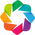

:DynamicMap   [otime]
   :Overlay
      .Image.I  :Image   [x,y]   (core__labprop_Qs)
      .Image.II :Image   [x,y]   (core__HS)

In [14]:
import hvplot.xarray
import holoviews as hv
import datashader
import xarray as xr


hv.extension('bokeh')
wi, he = 600,500

topo = out_ds.core__topo.hvplot.image(
    x='x', y='y',
    width = wi, height = he,
    cmap=plt.cm.gist_earth, groupby='otime', dynamic = True
)

Qw = np.log10(out_ds.core__Q_water).hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (3,8),
    cmap=plt.cm.Blues, groupby='otime', dynamic = True
)


HS = out_ds.core__HS.hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,250),
    cmap=plt.cm.gray, groupby='otime', alpha = 0.45, dynamic = True
)

SH = out_ds.core__sed_thickness.hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,5),
    cmap=plt.cm.viridis, groupby='otime', alpha = 0.6, dynamic = True
)

prop = out_ds.core__labprop_superficial_layer.sel(n_labels = 2).hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,1),
    cmap=plt.cm.magma, groupby='otime', alpha = 1, dynamic = True
)

prop_QS = out_ds.core__labprop_Qs.sel(n_labels = 2).hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,1),
    cmap=plt.cm.magma, groupby='otime', alpha = 1, dynamic = True
)


prop_delta = (out_ds.core__labprop_Qs.sel(n_labels = 0) - out_ds.core__labprop_superficial_layer.sel(n_labels = 0)).hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,0.1),
    cmap=plt.cm.magma, groupby='otime', alpha = 1, dynamic = True
)

E_s = out_ds.core__E_s.hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (0,1e-6),
    cmap=plt.cm.magma, groupby='otime', alpha = 1, dynamic = True
)

E_r = out_ds.core__E_r.hvplot.image(
    x='x', y='y',
    width = wi, height = he,# clim = (0,1e-3),
    cmap=plt.cm.magma, groupby='otime', alpha = 1, dynamic = True
)
# core__labprop_Qs
LD = out_ds.core__lake_depth.hvplot.image(
    x='x', y='y',
    width = wi, height = he, clim = (-1,0),
    cmap=plt.cm.Blues, groupby='otime', alpha = 0.6, dynamic = True
)

# LiDr = out_ds.core__lake_id_raw.hvplot.image(
#     x='x', y='y',
#     width = wi, height = he, 
#     cmap=plt.cm.jet, groupby='otime', alpha = 0.6, dynamic = True
# )

# mstack = out_ds.core__mstack_checker.hvplot.image(
#     x='x', y='y',
#     width = wi, height = he, 
#     cmap=plt.cm.jet, groupby='otime', alpha = 0.3, dynamic = True
# )

# Qw * LiDr
prop_QS * HS


In [ ]:
# np.save("SStopo50_50.npy",out_ds.core__topo.values[-1], )

In [ ]:
# from PIL import Image, ImageDraw
# fy = (prop * HS)
# cpt = 0
# for i in fy:
#     name = str(cpt)
#     while(len(name) < 4):
#         name = "0" + name
#     hv.save(i,"temp_output" +  name + ".png", fmt = "png")

In [ ]:
# from PIL import Image, ImageDraw


In [12]:
del prop

In [ ]:
previous = 0
for val,lake in zip(out_ds.core__Q_water.values,out_ds.core__lake_depth.values):
    this_lake_stuff = np.nansum(np.abs(lake)) * dx * dy/dt
    print(np.sum(val[0,:]) + np.sum(val[-1,:]) + this_lake_stuff - previous)
    previous = this_lake_stuff
    
print(dx*dy * ny * nx)

In [ ]:
%matplotlib widget
plt.imshow(Z)